In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

def get_datasets(num_epochs: int, batch_size: int):
    """Load the MNIST dataset and prepare it for training."""
    train_ds = tfds.load('mnist', split='train')
    test_ds = tfds.load('mnist', split='test')

    train_ds = train_ds.map(lambda sample: 
            {'image': tf.cast(sample['image'], tf.float32) / 255.0,
            'label': sample['label']})
    test_ds = test_ds.map(lambda sample: 
            {'image': tf.cast(sample['image'], tf.float32) / 255.0,
            'label': sample['label']})
    
    train_ds = train_ds.repeat(num_epochs).shuffle(1024)
    train_ds = train_ds.batch(batch_size, drop_remainder=True)
    test_ds = test_ds.shuffle(1024).batch(batch_size, drop_remainder=True)

    return train_ds, test_ds
                            

In [2]:
from flax import linen as nn

class CNN(nn.Module):
    """A simple CNN model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x
        

In [3]:
import jax
import jax.numpy as jnp

cnn = CNN()
print(cnn.tabulate(jax.random.key(0), jnp.ones((1, 28, 28, 1)),
                   compute_flops=True, compute_vjp_flops=True))


                                  CNN Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs     ┃ outputs   ┃ flops   ┃ vjp_flops ┃ params     ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━┩
│         │ CNN    │ float32[1… │ float32[… │ 8708106 │ 26957556  │            │
├─────────┼────────┼────────────┼───────────┼─────────┼───────────┼────────────┤
│ Conv_0  │ Conv   │ float32[1… │ float32[… │ 455424  │ 1341472   │ bias:      │
│         │        │            │           │         │           │ float32[3… │
│         │        │            │           │         │           │ kernel:    │
│         │        │            │           │         │           │ float32[3… │
│         │        │            │           │         │           │            │
│         │        │            │           │         │           │ 320 (1.3   │
│         │        │       

In [4]:
!pip3 install -q clu optax

from clu import metrics
from flax.training import train_state
from flax import struct
import optax

/opt/homebrew/Cellar/python@3.11/3.11.11/Frameworks/Python.framework/Versions/3.11/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [6]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, momentum):
    """Creates the initial TrainState"""
    #passing a template image to initialise the parameters of the layers
    params = module.init(rng, jnp.ones([1, 28, 28, 1]))['params']
    tx = optax.sgd(learning_rate, momentum)
    return TrainState.create(
        apply_fn=module.apply, params=params, tx=tx,
        metrics=Metrics.empty())

In [7]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch['image'])
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch['label']).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [8]:
@jax.jit
def compute_metrics(*, state, batch):
    logits = state.apply_fn({'params': state.params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch['label']).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=batch['label'], loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state


In [9]:
num_epochs = 10
batch_size = 32

train_ds, test_ds = get_datasets(num_epochs, batch_size)

In [10]:
tf.random.set_seed(0)
init_rng = jax.random.key(0)

In [11]:
learning_rate = 0.01
momentum = 0.9

state = create_train_state(cnn, init_rng, learning_rate, momentum)
del init_rng

In [12]:
#dont understand this part
num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs
# something to do with the fact that the data is replicated
# num epoch times in get_datasets()

In [13]:
metrics_history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': []
}

In [14]:
for step, batch in enumerate(train_ds.as_numpy_iterator()):

    state = train_step(state, batch) # get updated training state with parameters
    state = compute_metrics(state=state, batch=batch) # aggregate batch metrics

    if (step+1) % num_steps_per_epoch == 0:
        for metric, value in state.metrics.compute().items():
            metrics_history[f'train_{metric}'].append(value)
        # reset train_metrics for next training epoch
        state = state.replace(metrics=state.metrics.empty())

        test_state = state
        for test_batch in test_ds.as_numpy_iterator():
            test_state = compute_metrics(state=test_state, batch=test_batch)

        for metric, value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)
        
        print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
        print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")



train epoch: 1, loss: 0.18365369737148285, accuracy: 94.461669921875
test epoch: 1, loss: 0.10233663022518158, accuracy: 96.82492065429688
train epoch: 2, loss: 0.055167604237794876, accuracy: 98.4183349609375
test epoch: 2, loss: 0.04783007502555847, accuracy: 98.55769348144531
train epoch: 3, loss: 0.03761307895183563, accuracy: 98.91166687011719
test epoch: 3, loss: 0.044143203645944595, accuracy: 98.60777282714844
train epoch: 4, loss: 0.027373025193810463, accuracy: 99.20500183105469
test epoch: 4, loss: 0.03391415253281593, accuracy: 98.90824890136719
train epoch: 5, loss: 0.02105293795466423, accuracy: 99.39500427246094
test epoch: 5, loss: 0.03192783519625664, accuracy: 99.04847717285156
train epoch: 6, loss: 0.016310449689626694, accuracy: 99.51333618164062
test epoch: 6, loss: 0.033664047718048096, accuracy: 98.91827392578125
train epoch: 7, loss: 0.012831021100282669, accuracy: 99.6883316040039
test epoch: 7, loss: 0.03300875425338745, accuracy: 98.9883804321289
train epoch:

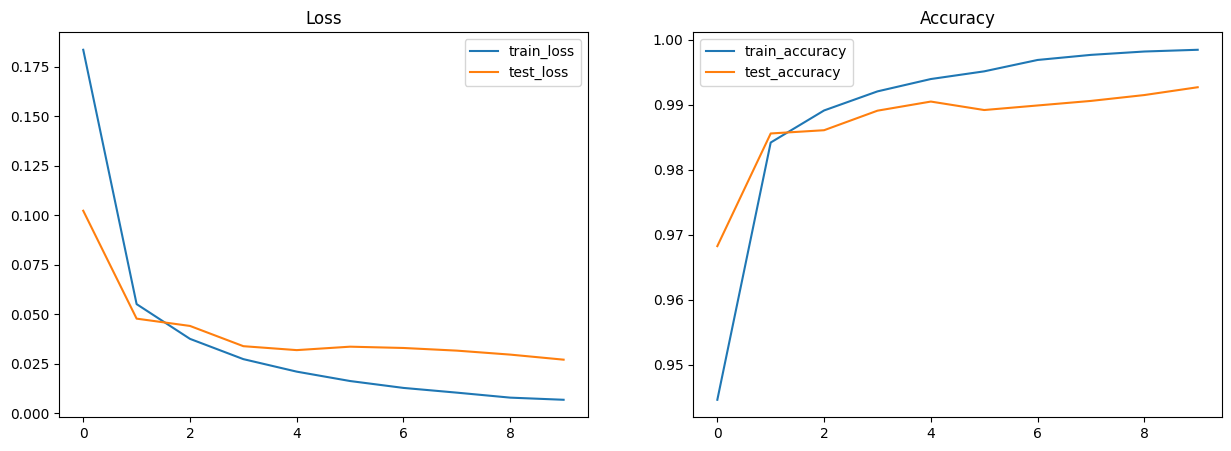

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

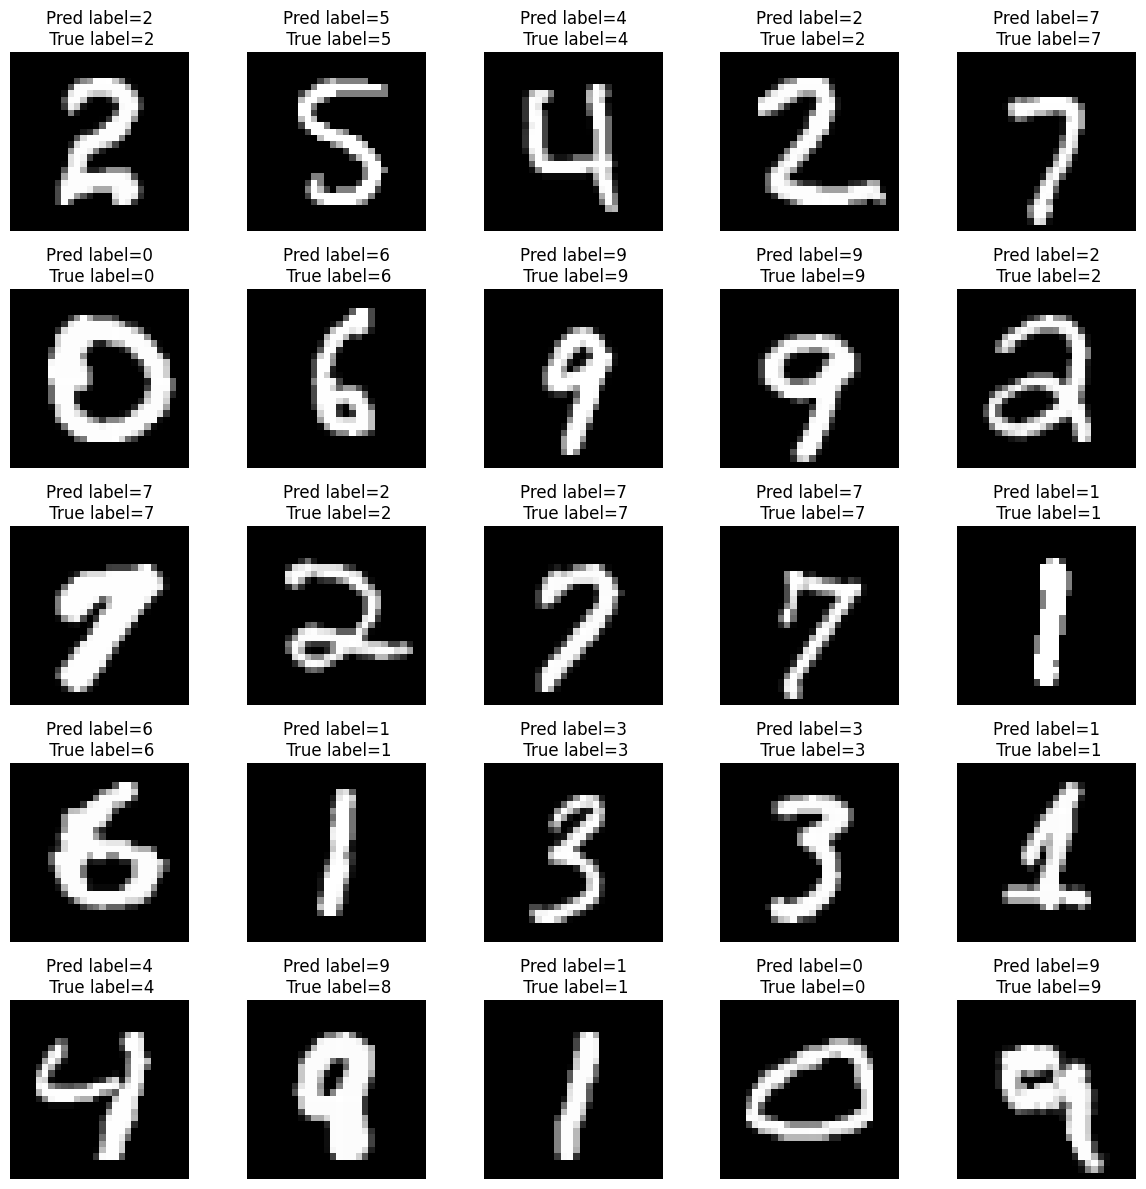

In [20]:
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, test_batch['image'])
  return logits.argmax(axis=1)

test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(state, test_batch)

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
    ax.set_title(f"Pred label={pred[i]}\n True label={test_batch['label'][i]}")
    ax.axis('off')
plt.tight_layout()